📦 Checking and installing dependencies...
✅ Dependencies already installed.
🚀 Initializing Service with model: Lykon/dreamshaper-8...
🖥️  Running on device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✨ Model loaded successfully.

⬇️  PLEASE UPLOAD A PET IMAGE BELOW ⬇️


Saving IMG_4107.PNG to IMG_4107.PNG

🐶 Is this a Dog or a Cat?
Type 'dog', 'cat', 'hamster', etc: cat

Select a style:
1. Oil Painting, thick strokes, textured canvas
2. Pixar style, disney 3d render, cute, vibrant
3. Cyberpunk, neon lights, mechanical parts, sci-fi
4. Pencil sketch, graphite, monochrome, rough lines
5. Ghibli style, anime, vibrant colors, detailed background
Enter number (1-5): 4
🎨 Generating: 'Pencil sketch, graphite, monochrome, rough lines' for species 'cat'...


  0%|          | 0/16 [00:00<?, ?it/s]


✅ Generation Complete!
Original:


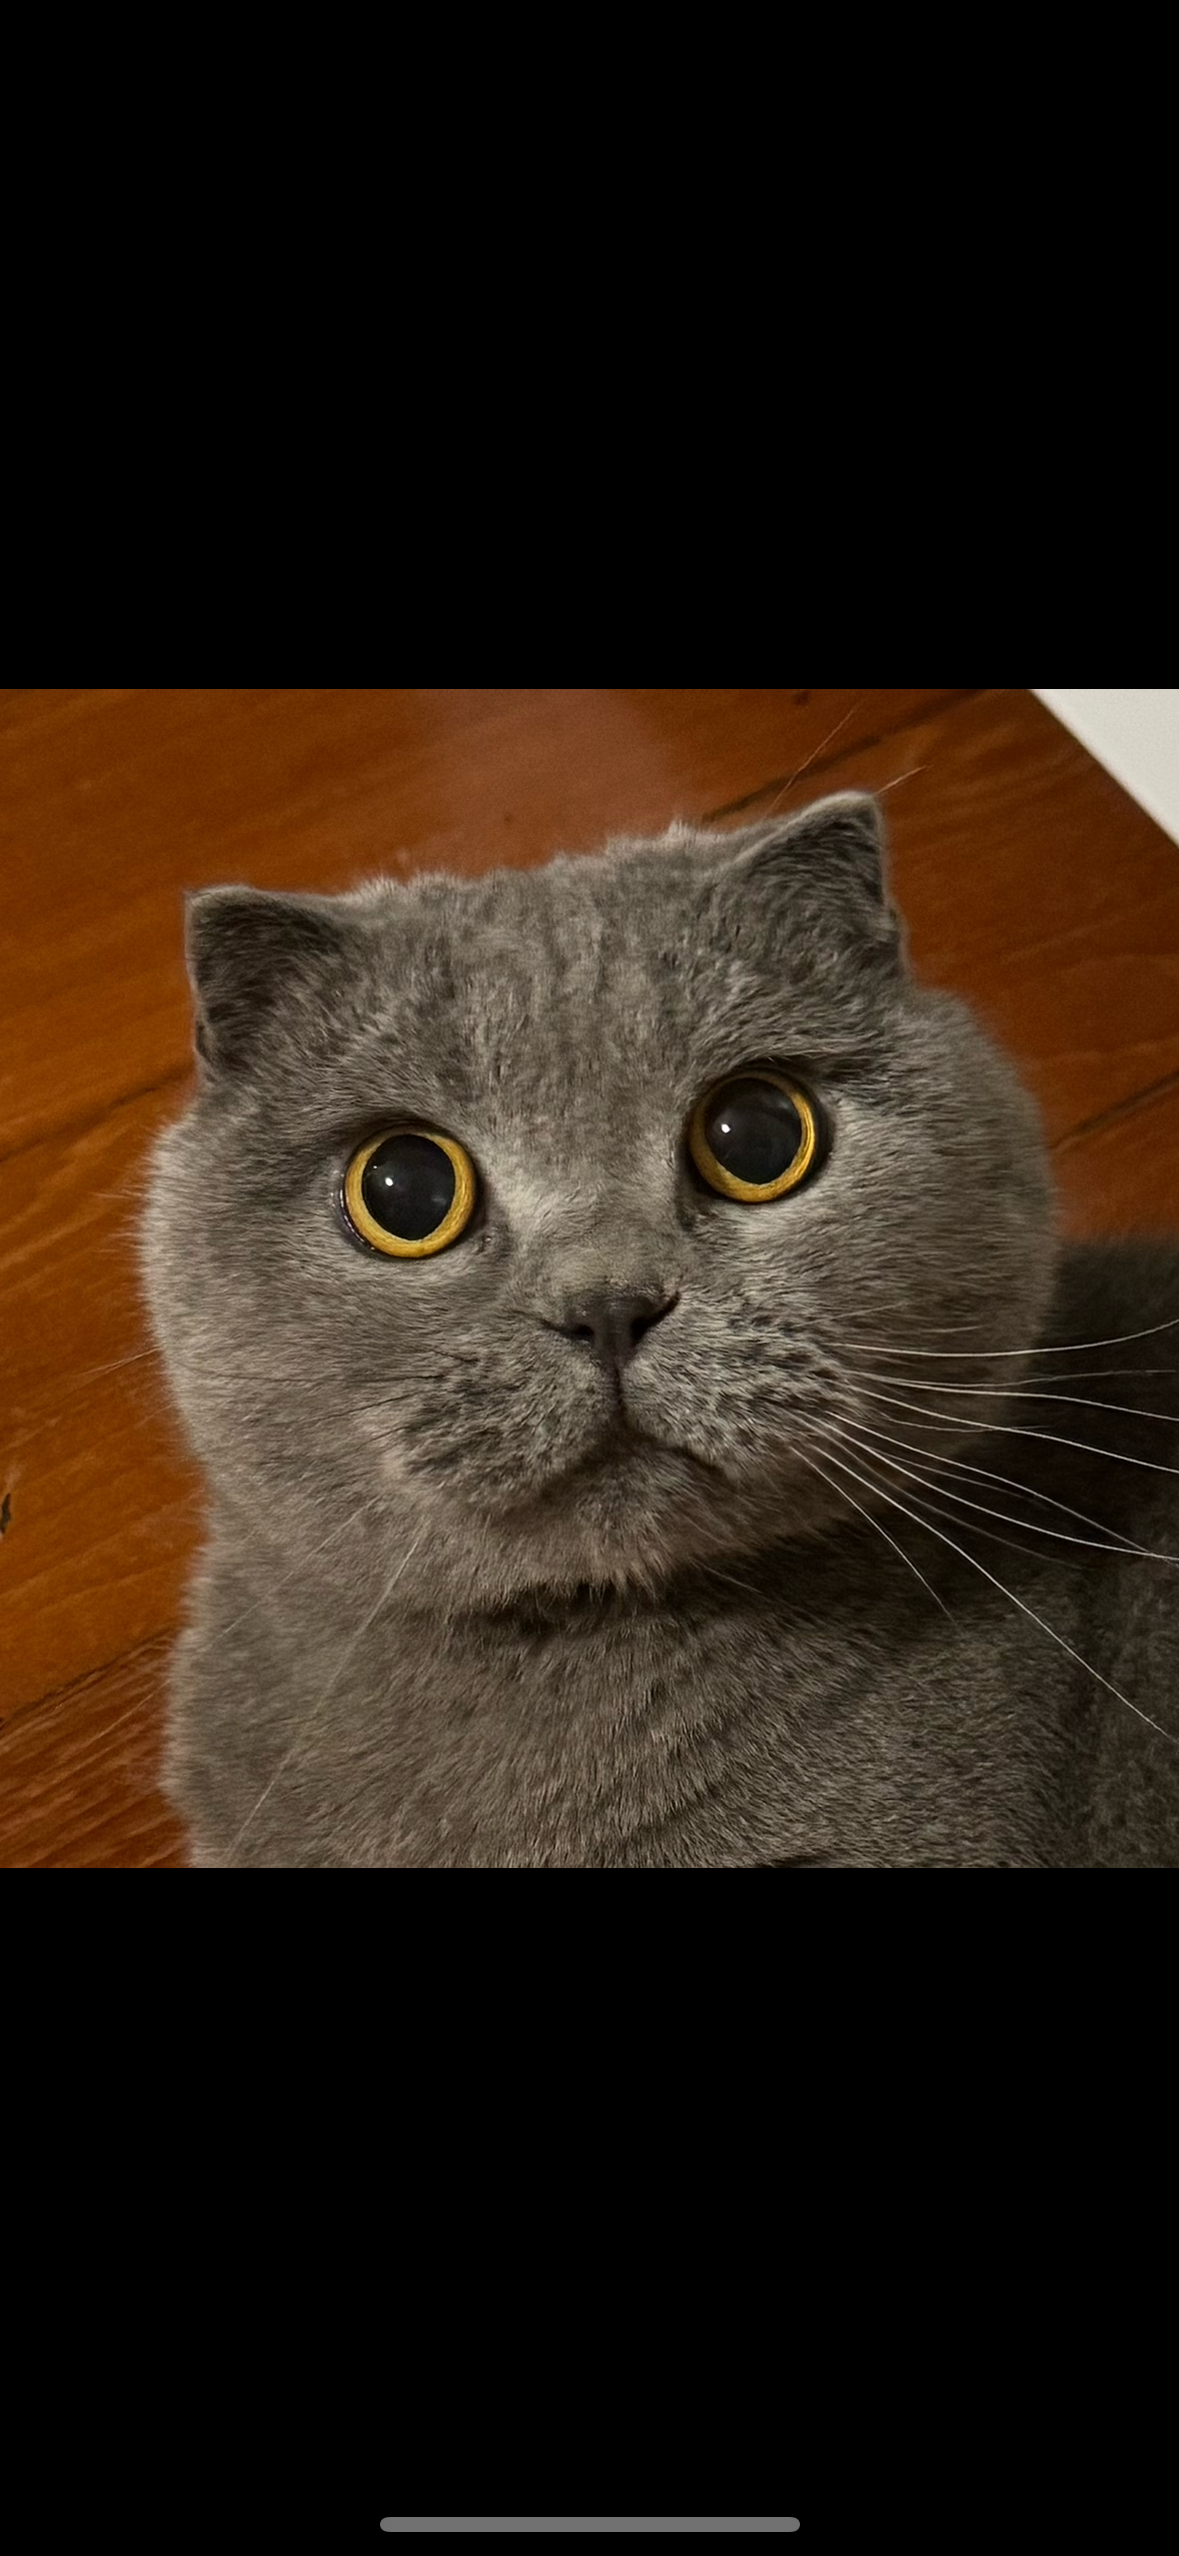


Result (Pencil sketch, graphite, monochrome, rough lines):


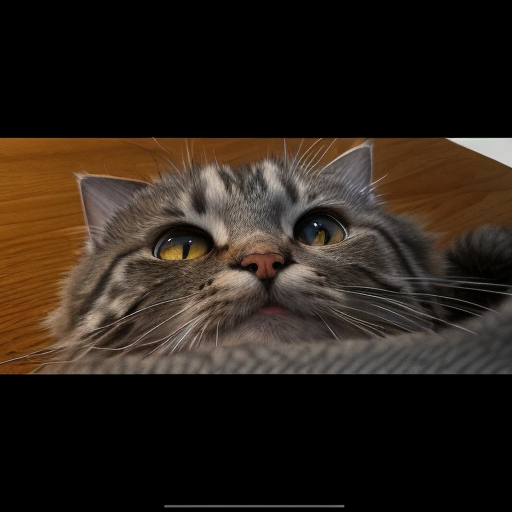

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# =============================================================================
# PET STYLE SERVICE - GOOGLE COLAB RUNNER (SPECIES SPECIFIC VERSION)
# =============================================================================
# Updates:
# - ADDED: 'species' parameter to prevent Dog<->Cat swapping.
# - ADDED: Interactive input to ask user for the animal type.
# - UPDATED: Prompt weights to prioritize species identity.
# =============================================================================

import os
import sys
import subprocess
from PIL import Image
import torch

# --- 1. Automatic Dependency Installation ---
print("📦 Checking and installing dependencies...")
required_packages = ["diffusers", "transformers", "accelerate", "safetensors"]
try:
    import diffusers
    print("✅ Dependencies already installed.")
except ImportError:
    print("⬇️ Installing libraries (this takes about 30s)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + required_packages)
    print("✅ Installation complete.")

# --- 2. Define the Service Class (Self-Contained) ---
from diffusers import StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler

class PetStyleService:
    def __init__(self, model_id="Lykon/dreamshaper-8"):
        print(f"🚀 Initializing Service with model: {model_id}...")

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"🖥️  Running on device: {self.device}")

        if self.device == "cpu":
            print("⚠️ WARNING: You are not using a GPU. Go to Runtime > Change runtime type > Hardware accelerator > GPU.")

        dtype = torch.float16 if self.device == "cuda" else torch.float32

        try:
            self.pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
                model_id,
                torch_dtype=dtype,
                use_safetensors=True
            )

            # Use DPMSolver++ for quality
            self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(
                self.pipe.scheduler.config,
                use_karras_sigmas=True,
                algorithm_type="dpmsolver++"
            )

            self.pipe = self.pipe.to(self.device)
            if self.device == "cuda":
                self.pipe.enable_attention_slicing()
            print("✨ Model loaded successfully.")
        except Exception as e:
            print(f"❌ Failed to load model: {e}")
            raise e

    # UPDATED: Added 'species' argument
    def transform_image(self, input_image_path, output_path, style_prompt, species="dog", strength=0.75):
        try:
            init_image = Image.open(input_image_path).convert("RGB")
            init_image = init_image.resize((512, 512))

            # UPDATED: We inject the specific species heavily (1.5 weight)
            # We also remove "pet" to avoid ambiguity
            full_prompt = (
                f"masterpiece, best quality, highres, (A cute {species}:1.5), (animal only:1.2), {style_prompt}, "
                f"8k, extremely detailed, cinematic lighting"
            )

            negative_prompt = (
                "human, person, people, man, woman, girl, boy, child, human face, human body, hands, feet, "
                "worst quality, low quality, normal quality, lowres, blurry, "
                "bad anatomy, disfigured, text, watermark, ugly, painting frame, extra limbs"
            )

            print(f"🎨 Generating: '{style_prompt}' for species '{species}'...")

            image = self.pipe(
                prompt=full_prompt,
                image=init_image,
                strength=strength,
                guidance_scale=7.5,
                negative_prompt=negative_prompt,
                num_inference_steps=30
            ).images[0]

            image.save(output_path)
            return output_path
        except Exception as e:
            print(f"❌ Error: {e}")
            return None

# --- 3. Interactive Colab UI ---
def run_interactive_demo():
    try:
        from google.colab import files
        from IPython.display import display, Image as IPImage
    except ImportError:
        print("❌ Not running in Google Colab. This section requires Colab environment.")
        return

    service = PetStyleService()

    print("\n⬇️  PLEASE UPLOAD A PET IMAGE BELOW ⬇️")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    input_filename = list(uploaded.keys())[0]

    # UPDATED: Ask user for species
    print("\n🐶 Is this a Dog or a Cat?")
    species_input = input("Type 'dog', 'cat', 'hamster', etc: ").strip().lower()
    if not species_input:
        species_input = "dog" # Default

    styles = {
        "1": ("Oil Painting, thick strokes, textured canvas", 0.65),
        "2": ("Pixar style, disney 3d render, cute, vibrant", 0.70),
        "3": ("Cyberpunk, neon lights, mechanical parts, sci-fi", 0.75),
        "4": ("Pencil sketch, graphite, monochrome, rough lines", 0.55),
        "5": ("Ghibli style, anime, vibrant colors, detailed background", 0.65)
    }

    print("\nSelect a style:")
    for k, v in styles.items():
        print(f"{k}. {v[0]}")

    choice = input("Enter number (1-5): ")
    style_name, strength = styles.get(choice, styles["1"])

    output_filename = f"generated_{choice}.png"

    # Pass species to transform
    result = service.transform_image(input_filename, output_filename, style_name, species=species_input, strength=strength)

    if result:
        print("\n✅ Generation Complete!")
        print("Original:")
        display(IPImage(input_filename, width=300))
        print(f"\nResult ({style_name}):")
        display(IPImage(output_filename, width=300))

        files.download(output_filename)

if __name__ == "__main__":
    run_interactive_demo()